In [1]:
# Requirements numpy-1.15.0 pandas-0.23.4 
# update conda and pip using:
# conda update pandas 
# pip install -U pandas

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import chi2
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from collections import Counter

from io import StringIO

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

df = pd.read_csv('Data_ML.csv', delimiter=',', encoding="utf-8-sig")
df.head()
df.columns



Index(['Identifier', 'Company Name', 'Business Description',
       'TRBC Economic Sector Name', 'Unnamed: 4'],
      dtype='object')

In [3]:
df.head()

,Identifier,Company Name,Business Description,TRBC Economic Sector Name,Unnamed: 4
0,CMI.N,Cummins Inc,"Cummins Inc. designs, manufactures, distribute...",Consumer Cyclicals,NaN
1,RIO.L,Rio Tinto PLC,Rio Tinto plc is a mining and metals company. ...,Basic Materials,NaN
2,RIO.AX,Rio Tinto Ltd,Rio Tinto Limited (Rio Tinto) is a mining comp...,Basic Materials,NaN
3,RDSa.AS,Royal Dutch Shell PLC,The Royal Dutch Shell plc explores for crude o...,Energy,NaN
4,BLT.L,BHP Billiton PLC,BHP Billiton Plc is a global resources company...,Basic Materials,NaN


In [4]:
#drop that 4th column (must have pandas 0.21 to use "drop" function)
df = df.drop(columns=['Unnamed: 4'])

In [5]:
df.columns

Index(['Identifier', 'Company Name', 'Business Description',
       'TRBC Economic Sector Name'],
      dtype='object')

In [6]:
#Renaming columns so we can work with data
df.columns=['Identifier', 'Company_Name', 'Business_Description', 'TRBC_Economic_Sector_Name']

In [7]:
df.columns

Index(['Identifier', 'Company_Name', 'Business_Description',
       'TRBC_Economic_Sector_Name'],
      dtype='object')

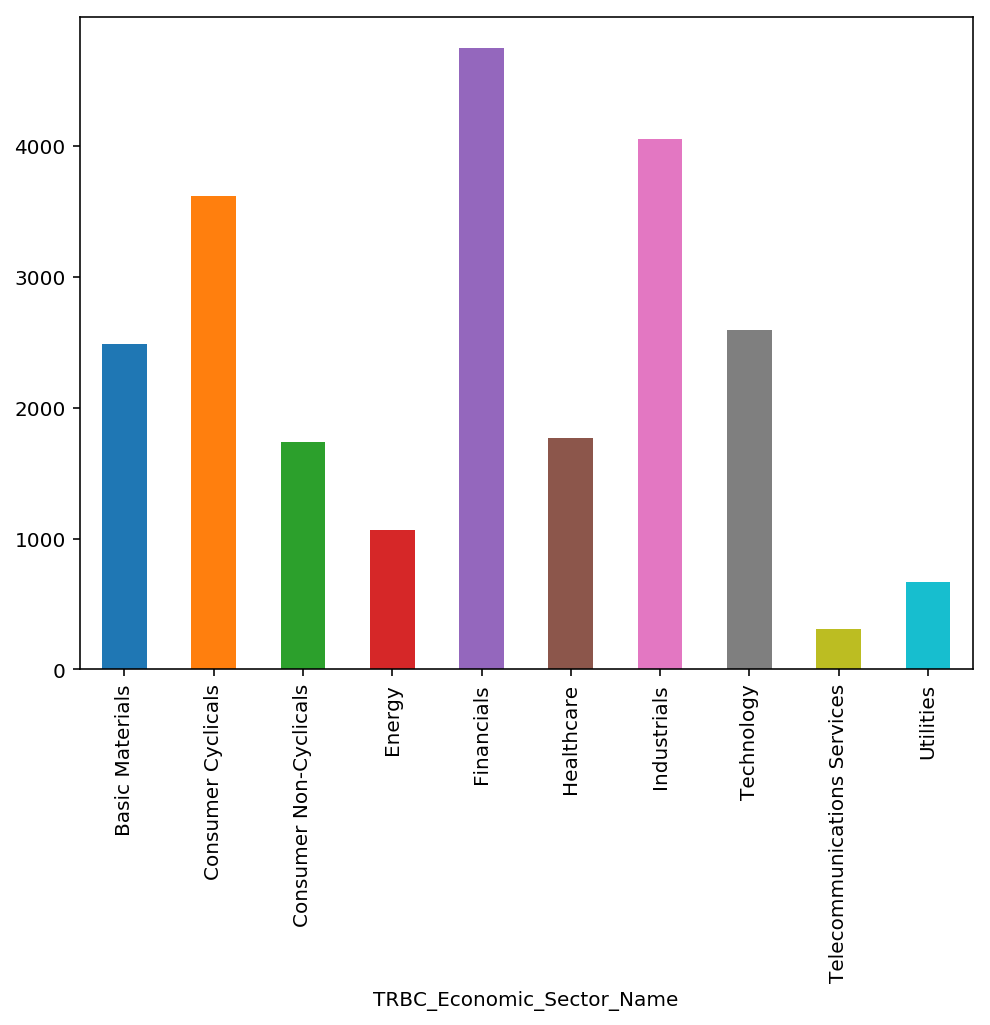

In [8]:
#Distribution of companies across economic sectors
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('TRBC_Economic_Sector_Name').Company_Name.count().plot.bar(ylim=0)
plt.show()

In [9]:
# Adding Sector_id column so we can run a chi-squared test...
df['Sector_id'] = df['TRBC_Economic_Sector_Name'].factorize()[0]
Sector_id_df = df[['TRBC_Economic_Sector_Name', 'Sector_id']].drop_duplicates().sort_values('Sector_id')
Sector_to_id = dict(Sector_id_df.values)
id_to_Sector = dict(Sector_id_df[['Sector_id', 'TRBC_Economic_Sector_Name']].values)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

df.Business_Description = df['Business_Description'].values.astype('U').tolist()
features = tfidf.fit_transform(df.Business_Description).toarray()

labels = df.Sector_id
features.shape

/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(23036, 49538)

In [10]:
df.head()

,Identifier,Company_Name,Business_Description,TRBC_Economic_Sector_Name,Sector_id
0,CMI.N,Cummins Inc,"Cummins Inc. designs, manufactures, distribute...",Consumer Cyclicals,0
1,RIO.L,Rio Tinto PLC,Rio Tinto plc is a mining and metals company. ...,Basic Materials,1
2,RIO.AX,Rio Tinto Ltd,Rio Tinto Limited (Rio Tinto) is a mining comp...,Basic Materials,1
3,RDSa.AS,Royal Dutch Shell PLC,The Royal Dutch Shell plc explores for crude o...,Energy,2
4,BLT.L,BHP Billiton PLC,BHP Billiton Plc is a global resources company...,Basic Materials,1


In [11]:
# Using chi2 to find terms in Business_Desciption most correlated with each TRBC_Economic_Sector_Name
N = 2
for TRBC_Economic_Sector_Name, Sector_id in sorted(Sector_to_id.items()):
  features_chi2 = chi2(features, labels == Sector_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(TRBC_Economic_Sector_Name))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Basic Materials':
  . Most correlated unigrams:
. steel
. cement
  . Most correlated bigrams:
. steel products
. chemical products
# 'Consumer Cyclicals':
  . Most correlated unigrams:
. stores
. apparel
  . Most correlated bigrams:
. department stores
. men women
# 'Consumer Non-Cyclicals':
  . Most correlated unigrams:
. foods
. food
  . Most correlated bigrams:
. dairy products
. food products
# 'Energy':
  . Most correlated unigrams:
. gas
. oil
  . Most correlated bigrams:
. natural gas
. crude oil
# 'Financials':
  . Most correlated unigrams:
. banking
. bank
  . Most correlated bigrams:
. investment trust
. real estate
# 'Healthcare':
  . Most correlated unigrams:
. drugs
. pharmaceutical
  . Most correlated bigrams:
. pharmaceutical products
. biopharmaceutical company
# 'Industrials':
  . Most correlated unigrams:
. equipment
. engineering
  . Most correlated bigrams:
. engaged construction
. civil engineering
# 'Technology':
  . Most correlated unigrams:
. semiconductor
. 

In [12]:
#Moving on to process data for Naive Bayes testing

def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return str(text).translate(translator)

In [13]:
df['Business_Description'] = df['Business_Description'].apply(remove_punctuation)
df.head(10)

,Identifier,Company_Name,Business_Description,TRBC_Economic_Sector_Name,Sector_id
0,CMI.N,Cummins Inc,Cummins Inc designs manufactures distributes a...,Consumer Cyclicals,0
1,RIO.L,Rio Tinto PLC,Rio Tinto plc is a mining and metals company T...,Basic Materials,1
2,RIO.AX,Rio Tinto Ltd,Rio Tinto Limited Rio Tinto is a mining compan...,Basic Materials,1
3,RDSa.AS,Royal Dutch Shell PLC,The Royal Dutch Shell plc explores for crude o...,Energy,2
4,BLT.L,BHP Billiton PLC,BHP Billiton Plc is a global resources company...,Basic Materials,1
5,BHP.AX,BHP Billiton Ltd,BHP Billiton Limited is a global resources com...,Basic Materials,1
6,PETR4.SA,Petroleo Brasileiro SA Petrobras,Petroleo Brasileiro SAPetrobras specializes in...,Energy,2
7,TOTF.PA,Total SA,Total SA Total is an oil and gas company The C...,Energy,2
8,7203.T,Toyota Motor Corp,Toyota Motor Corporation Toyota conducts busin...,Consumer Cyclicals,0
9,BP.L,BP PLC,BP plc is an integrated oil and gas company Th...,Energy,2


In [14]:
# extracting the stopwords from nltk library
sw = stopwords.words('english')

In [15]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [16]:
df['Business_Description'] = df['Business_Description'].apply(stopwords)
df.head(10)

,Identifier,Company_Name,Business_Description,TRBC_Economic_Sector_Name,Sector_id
0,CMI.N,Cummins Inc,cummins inc designs manufactures distributes s...,Consumer Cyclicals,0
1,RIO.L,Rio Tinto PLC,rio tinto plc mining metals company companys b...,Basic Materials,1
2,RIO.AX,Rio Tinto Ltd,rio tinto limited rio tinto mining company com...,Basic Materials,1
3,RDSa.AS,Royal Dutch Shell PLC,royal dutch shell plc explores crude oil natur...,Energy,2
4,BLT.L,BHP Billiton PLC,bhp billiton plc global resources company comp...,Basic Materials,1
5,BHP.AX,BHP Billiton Ltd,bhp billiton limited global resources company ...,Basic Materials,1
6,PETR4.SA,Petroleo Brasileiro SA Petrobras,petroleo brasileiro sapetrobras specializes oi...,Energy,2
7,TOTF.PA,Total SA,total sa total oil gas company company three s...,Energy,2
8,7203.T,Toyota Motor Corp,toyota motor corporation toyota conducts busin...,Consumer Cyclicals,0
9,BP.L,BP PLC,bp plc integrated oil gas company company owns...,Energy,2


In [17]:
# create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(df['Business_Description'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items() 

In [18]:
# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [19]:
df['Business_Description'] = df['Business_Description'].apply(stemming)
df.head(10)

,Identifier,Company_Name,Business_Description,TRBC_Economic_Sector_Name,Sector_id
0,CMI.N,Cummins Inc,cummin inc design manufactur distribut servic ...,Consumer Cyclicals,0
1,RIO.L,Rio Tinto PLC,rio tinto plc mine metal compani compani busi ...,Basic Materials,1
2,RIO.AX,Rio Tinto Ltd,rio tinto limit rio tinto mine compani compani...,Basic Materials,1
3,RDSa.AS,Royal Dutch Shell PLC,royal dutch shell plc explor crude oil natur g...,Energy,2
4,BLT.L,BHP Billiton PLC,bhp billiton plc global resourc compani compan...,Basic Materials,1
5,BHP.AX,BHP Billiton Ltd,bhp billiton limit global resourc compani comp...,Basic Materials,1
6,PETR4.SA,Petroleo Brasileiro SA Petrobras,petroleo brasileiro sapetrobra special oil nat...,Energy,2
7,TOTF.PA,Total SA,total sa total oil gas compani compani three s...,Energy,2
8,7203.T,Toyota Motor Corp,toyota motor corpor toyota conduct busi automo...,Consumer Cyclicals,0
9,BP.L,BP PLC,bp plc integr oil gas compani compani own inte...,Energy,2


In [20]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer("english")
# fit the vectorizer using the text data
tfid_vectorizer.fit(df['Business_Description'])
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items() 

In [21]:
# The reason I've doubled up here with tfidf initialization is so the output of the prediction is a string, and not the 
# Sector_id number

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Business_Description).toarray()
labels = df.TRBC_Economic_Sector_Name


/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [22]:
# TESTING WITH NAIVE BAYES # 

X_train, X_test, y_train, y_test = train_test_split(df['Business_Description'], df['TRBC_Economic_Sector_Name'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()

X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)



/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [23]:
#TESTING SPECIFIC CASES

In [24]:
#TESTING PG&E (Incorrect -- should be Utilities)
print(clf.predict(count_vect.transform(["PG&E Corporation is a holding company. The Company's primary operating subsidiary is Pacific Gas and Electric Company (the Utility), which operates in northern and central California. The Utility is engaged in the sale and delivery of electricity and natural gas to customers. The Utility generates electricity and provides electricity transmission and distribution services throughout its service territory in northern and central California to residential, commercial, industrial, and agricultural customers. The Utility provides bundled services (electricity, transmission and distribution services) to various customers in its service territory. As of December 31, 2016, the Utility owned approximately 18,400 circuit miles of interconnected transmission lines operating at voltages ranging from 60 kilovolt to 500 kilovolt. As of December 31, 2016, the Utility also operated 92 electric transmission substations with a capacity of approximately 64,600 megavolt ampere (MVA)."])))

['Financials']


In [25]:
#TESTING PEPSI (Correct)
print(clf.predict(count_vect.transform(["PepsiCo, Inc. is a global food and beverage company. The Company's portfolio of brands includes Frito-Lay, Gatorade, Pepsi-Cola, Quaker and Tropicana. The Company operates through six segments: Frito-Lay North America (FLNA), Quaker Foods North America (QFNA), North America Beverages (NAB), Latin America, Europe Sub-Saharan Africa (ESSA), and Asia, Middle East and North Africa (AMENA). The FLNA segment includes its branded food and snack businesses in the United States and Canada. The QFNA segment includes its cereal, rice, pasta and other branded food businesses in the United States and Canada. The NAB segment includes its beverage businesses in the United States and Canada. The Latin America segment includes its beverage, food and snack businesses in Latin America. The ESSA segment includes its beverage, food and snack businesses in Europe and Sub-Saharan Africa. The AMENA segment includes its beverage, food and snack businesses in Asia, Middle East and North Africa."])))

['Consumer Non-Cyclicals']


In [26]:
#TESTING MICROSOFT (Correct)
print(clf.predict(count_vect.transform(["Microsoft Corporation is a technology company. The Company develops, licenses, and supports a range of software products, services and devices. The Company's segments include Productivity and Business Processes, Intelligent Cloud and More Personal Computing. The Company's products include operating systems; cross-device productivity applications; server applications; business solution applications; desktop and server management tools; software development tools; video games, and training and certification of computer system integrators and developers. It also designs, manufactures, and sells devices, including personal computers (PCs), tablets, gaming and entertainment consoles, phones, other intelligent devices, and related accessories, that integrate with its cloud-based offerings. It offers an array of services, including cloud-based solutions that provide customers with software, services, platforms, and content, and it provides solution support and consulting services."])))

['Technology']


In [27]:
# Test individual case here by pasting business description between quotes:
print(clf.predict(count_vect.transform([""])))

['Financials']


In [28]:
#CALCULATING OVERALL ACCURACY (w/ condensed testing syntax)

counter = Counter(df['TRBC_Economic_Sector_Name'].tolist())
top_10_sectors = {i[0]: idx for idx, i in enumerate(counter.most_common(10))}
df = df[df['TRBC_Economic_Sector_Name'].map(lambda x: x in top_10_sectors)]

description_list = df['Business_Description'].values.astype('U').tolist()

sector_list = [top_10_sectors[i] for i in df['TRBC_Economic_Sector_Name'].tolist()]
sector_list = np.array(sector_list)

count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(description_list)

tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

train_x, test_x, train_y, test_y = train_test_split(x_train_tfidf, sector_list, test_size=0.3)

clf = MultinomialNB().fit(train_x, train_y)
y_score = clf.predict(test_x)

n_right = 0
for i in range(len(y_score)):
    if y_score[i] == test_y[i]:
        n_right += 1

print("Accuracy: %.2f%%" % ((n_right/float(len(test_y)) * 100)))


Accuracy: 64.59%


/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
